Displacement data can be found in RIOT

## Load the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import xgboost as xgb
import tensorflow.keras
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics

## Load the data

In [2]:
prec = pd.read_csv('../data/timeseries_derived_data_products/MH25_vaisalawxt520prec_2017.csv', parse_dates=['time'])
wind = pd.read_csv('../data/timeseries_derived_data_products/MH25_vaisalawxt520windpth_2017.csv', parse_dates=['time'])
temp = pd.read_csv('../data/timeseries_derived_data_products/MH10_temperature_rock_2017.csv', parse_dates=['time'])
radio = pd.read_csv('../data/timeseries_derived_data_products/MH15_radiometer__conv_2017.csv', parse_dates=['time'])
displ = pd.read_csv('../data/MH8_displacement_2017_processed.csv')

In [3]:
displ = displ[['timed','displacement_dx1']]

In [4]:
displ = displ.set_index(displ['timed'])

In [5]:
displ.index = pd.to_datetime(displ.index, utc=True)

In [6]:
displ = displ.resample('60Min', how='mean', base=0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  """Entry point for launching an IPython kernel.


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


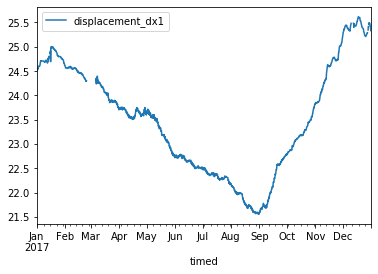

In [7]:
displ.plot()
plt.show()

In [8]:
displ = displ.dropna()

In [9]:
temp

,time,temperature_nearsurface_t2 [°C],device_id [],position [],ref1 [°C],ref2 [°C],ref3 [°C],ref4 [°C],ref5 [°C],temperature_10cm [°C],temperature_35cm [°C],temperature_60cm [°C],temperature_85cm [°C]
0,2017-01-01 00:00:00+00:00,-1.8219,2141.0,10.0,1.9563,-9.7372,1.0055,1.9538,-9.7387,-0.0335,1.4946,0.8955,-0.4628
1,2017-01-01 01:00:00+00:00,-2.2335,2141.0,10.0,1.9559,-9.7373,1.0055,1.9531,-9.7389,-0.4518,1.1538,0.8076,-0.4337
2,2017-01-01 02:00:00+00:00,-2.6047,2141.0,10.0,1.9557,-9.7378,1.0055,1.9531,-9.7386,-0.7957,0.8393,0.7098,-0.4143
3,2017-01-01 03:00:00+00:00,-2.9298,2141.0,10.0,1.9558,-9.7377,1.0054,1.9528,-9.7393,-1.1145,0.5453,0.6044,-0.4039
4,2017-01-01 04:00:00+00:00,-3.2746,2141.0,10.0,1.9556,-9.7378,1.0054,1.9531,-9.7394,-1.4527,0.2672,0.4918,-0.4016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2017-12-31 19:00:00+00:00,-1.8630,2141.0,10.0,1.9470,-9.7492,1.0040,1.9436,-9.7509,-0.7422,-1.6437,-4.2926,-5.9083
8756,2017-12-31 20:00:00+00:00,-2.6166,2141.0,10.0,1.9478,-9.7484,1.0040,1.9440,-9.7503,-1.3058,-1.8548,-4.1516,-5.7555
8757,2017-12-31 21:00:00+00:00,-3.3009,2141.0,10.0,1.9483,-9.7484,1.0040,1.9446,-9.7495,-1.8643,-2.0816,-4.0516,-5.6169
8758,2017-12-31 22:00:00+00:00,-3.8324,2141.0,10.0,1.9479,-9.7482,1.0040,1.9443,-9.7498,-2.3962,-2.3420,-3.9848,-5.4929


## Merge the datasets

In [10]:
temp_inner = pd.merge(left= temp, right=prec, left_on='time',right_on='time')
temp_inner = pd.merge(left= temp_inner, right=wind, left_on='time',right_on='time')
temp_inner = pd.merge(left=temp_inner, right=radio, left_on='time',right_on='time')
temp_inner = pd.merge(left=temp_inner, right=displ, left_on='time',right_on='timed')

## Select Columns

In [11]:
temp_inner['time'] = pd.to_datetime(temp_inner['time'])
temp_inner['season'] = np.round(pd.DatetimeIndex(temp_inner['time']).month/3)
del temp_inner['time']

temp_inner = temp_inner[['temperature_10cm [°C]',
       'temperature_35cm [°C]', 'temperature_60cm [°C]',
       'temperature_85cm [°C]', 'wind_speed_average [km/h]',
                         'net_radiation [Wm^-2]', 'season','displacement_dx1']]

temp_inner.dropna()

,temperature_10cm [°C],temperature_35cm [°C],temperature_60cm [°C],temperature_85cm [°C],wind_speed_average [km/h],net_radiation [Wm^-2],season,displacement_dx1
0,-0.0335,1.4946,0.8955,-0.4628,6.2129,-103.3271,0.0,24.508750
1,-0.4518,1.1538,0.8076,-0.4337,6.6033,-103.3083,0.0,24.509348
2,-0.7957,0.8393,0.7098,-0.4143,7.8323,-102.9365,0.0,24.509739
3,-1.1145,0.5453,0.6044,-0.4039,8.9094,-101.0145,0.0,24.511487
4,-1.4527,0.2672,0.4918,-0.4016,10.2742,-101.7435,0.0,24.513250
...,...,...,...,...,...,...,...,...
8224,-0.7422,-1.6437,-4.2926,-5.9083,14.4031,-94.8729,4.0,25.323352
8225,-1.3058,-1.8548,-4.1516,-5.7555,14.5226,-90.9528,4.0,25.323617
8226,-1.8643,-2.0816,-4.0516,-5.6169,17.6968,-85.6891,4.0,25.325616
8227,-2.3962,-2.3420,-3.9848,-5.4929,13.8333,-88.2355,4.0,25.328565


##  Create the target

In [12]:
lag = -1
#diff = temp_inner['temperature_100cm [°C]'] - temp_inner['temperature_5cm [°C]']
#temp_inner.insert(0, 'delta_t', diff)


# shift 
temp_inner['displacement_dx1'] = temp_inner['displacement_dx1'].shift(lag)
temp_inner = temp_inner.drop(temp_inner.index[temp_inner.shape[0] : temp_inner.shape[0] + lag])
temp_inner = temp_inner.replace(np.nan, 0)
temp_inner.head()

,temperature_10cm [°C],temperature_35cm [°C],temperature_60cm [°C],temperature_85cm [°C],wind_speed_average [km/h],net_radiation [Wm^-2],season,displacement_dx1
0,-0.0335,1.4946,0.8955,-0.4628,6.2129,-103.3271,0.0,24.509348
1,-0.4518,1.1538,0.8076,-0.4337,6.6033,-103.3083,0.0,24.509739
2,-0.7957,0.8393,0.7098,-0.4143,7.8323,-102.9365,0.0,24.511487
3,-1.1145,0.5453,0.6044,-0.4039,8.9094,-101.0145,0.0,24.513250
4,-1.4527,0.2672,0.4918,-0.4016,10.2742,-101.7435,0.0,24.515465


## Train test split

In [13]:
X, y = temp_inner.drop(['displacement_dx1'], axis=1), temp_inner['displacement_dx1']

In [14]:
# split train and validation data
validation_fraction = 0.2
validation_first = False


val_size = int(validation_fraction * X.shape[0])
train_size = X.shape[0] - val_size

if validation_first:
    X_train, X_val = Y[val_size:], X[:val_size]
    y_train, y_val = y[val_size:], y[:val_size]
    
else:
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]


In [15]:
X_val[-10:]

,temperature_10cm [°C],temperature_35cm [°C],temperature_60cm [°C],temperature_85cm [°C],wind_speed_average [km/h],net_radiation [Wm^-2],season
8219,5.7348,-1.6250,-5.8471,-6.6315,12.4871,-87.1849,4.0
8220,3.3538,-1.1900,-5.4398,-6.5215,15.1067,-86.6400,4.0
8221,1.6976,-1.1136,-5.0576,-6.3843,17.5258,-99.1272,4.0
8222,0.5919,-1.2312,-4.7382,-6.2310,11.5290,-92.9561,4.0
8223,-0.1218,-1.4292,-4.4861,-6.0698,11.7355,-96.2305,4.0
8224,-0.7422,-1.6437,-4.2926,-5.9083,14.4031,-94.8729,4.0
8225,-1.3058,-1.8548,-4.1516,-5.7555,14.5226,-90.9528,4.0
8226,-1.8643,-2.0816,-4.0516,-5.6169,17.6968,-85.6891,4.0
8227,-2.3962,-2.3420,-3.9848,-5.4929,13.8333,-88.2355,4.0
8228,-2.9045,-2.6282,-3.9463,-5.3815,14.4219,-87.2561,4.0


## Data Standartization

In [16]:
#Y_MEAN, Y_STD = y_train.mean(), y_train.std()

#y_train = (y_train - Y_MEAN)/Y_STD
#y_val   = (y_val -   Y_MEAN)/Y_STD
#X_MEAN, X_STD = X_train.mean(), X_train.std()
#X_train = (X_train - X_MEAN)/X_STD
#X_val = (X_val - X_MEAN)/X_STD

In [17]:
input_shape = X_train.shape
n_units = 80
n_layers = 3
n_frames = 5 # length of autoregressive sequence

In [18]:
input_shape

(6584, 7)

## Define the LSTM model

In [19]:
from tensorflow.keras import layers, models
i = layers.Input(shape = (n_frames, 7)) # (?, n_frames, channels) 

# add the lstm layers
x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=True)(i) # (?, n_units)
#x = layers.BatchNormalization()(x)
n_units *= 2

x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=True)(x) # (?, n_units)
#x = layers.BatchNormalization()(x)
n_units *= 2

x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=True)(x) # (?, n_units)
#x = layers.BatchNormalization()(x)
n_units *= 2

x = layers.LSTM(n_units, activation='tanh', recurrent_activation='hard_sigmoid', 
                   return_sequences=False)(x) # (?, n_units)
#x = layers.BatchNormalization()(x)
#n_units *= 2            

#x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Activation('relu')(x)

o = layers.Dense(1, activation = 'linear')(x)

In [20]:
model = models.Model(inputs=[i], outputs=[o])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 7)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 80)             28160     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 160)            154240    
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 320)            615680    
_________________________________________________________________
lstm_3 (LSTM)                (None, 640)               2460160   
_________________________________________________________________
dense (Dense)                (None, 128)               82048     
_________________________________________________________________
activation (Activation)      (None, 128)               0     

In [22]:
from tensorflow.keras import optimizers, losses, metrics
    
model.compile(optimizer=optimizers.Adam(lr=1e-3),
              loss=losses.mse)
              #metrics=[metrics.mse])

In [23]:
from tensorflow.keras import utils
class SequenceGenerator(utils.Sequence):
    '''Generates image sequences'''

    def __init__(self, data, labels, batch_size=32, n_frames=5):
        '''Initialization'''
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.n_frames = n_frames

    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        '''Generate one batch of data'''

        batch_x, batch_y = [], []

        for _ in range(self.batch_size):
            # Get start index of sequence
            start_index = np.random.randint(0, len(self.data) - self.n_frames)
            stop_index = start_index + self.n_frames

            # x = image sequence
            x = self.data[start_index:stop_index].values
            # y = streamflow at end point
            y = self.labels[stop_index]
            batch_x.append(x)
            batch_y.append(y)

        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)

        return batch_x, batch_y


In [24]:
batch_size = 120
n_epochs = 5
generator_train = SequenceGenerator(data = X_train, labels = y_train, batch_size = batch_size, n_frames = n_frames)
generator_test = SequenceGenerator(data = X_val, labels = y_val, batch_size = batch_size, n_frames = n_frames)

## Train the model

In [25]:
history = model.fit_generator(generator = generator_train,
                              steps_per_epoch = len(X_train)//batch_size,
                              epochs = n_epochs)

Epoch 1/5
54/54 [==============================] - 89s 2s/step - loss: 71.8704
Epoch 2/5
54/54 [==============================] - 77s 1s/step - loss: 0.9192
Epoch 3/5
54/54 [==============================] - 97s 2s/step - loss: 0.8098
Epoch 4/5
54/54 [==============================] - 83s 2s/step - loss: 0.6357
Epoch 5/5
54/54 [==============================] - 82s 2s/step - loss: 0.2770


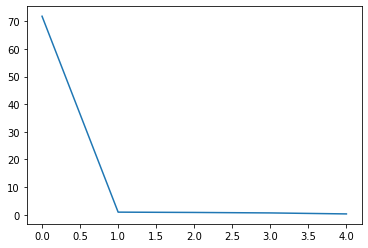

In [26]:
plt.plot(history.history['loss'])

## Test on validation set

In [ ]:
predictions = []
y_truth = []
for t in range(0, len(X_val)-n_frames):
    start_index = t
    stop_index = start_index + n_frames
    data = X_val[start_index : stop_index].values
    data = data[np.newaxis, ...]
    p = np.asscalar(model.predict( data))
    # p = p * y_std + y_mean
    predictions.append(p)
    y_truth.append(y_val.iloc[stop_index])

In [ ]:
pd.concat([pd.DataFrame(y_truth, columns=['True']), 
           pd.DataFrame(predictions, columns = ["Predicted"])], axis = 1).plot(figsize=(12,5))

In [ ]:
rmse = np.sqrt(metrics.mean_squared_error(y_truth, predictions))
print("The RMSE is " + str(rmse))

In [ ]:
y_truth[-10:]

In [ ]:
y_val[-10:]